In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# import pyecharts

In [4]:
def loadDataSet(fileName):
    numFeat = len(open(fileName).readline().strip().split('\t')) -1
    xArr = []
    yArr = []
    with open(fileName) as fr:
        for line in fr.readlines():
            currntLine = line.strip().split('\t')
            arr = []
            for i in range(numFeat):
                arr.append(float(currntLine[i]))
            xArr.append(arr)
            yArr.append(float(currntLine[-1])) # 列向量
    return xArr,yArr

def loadDataMat(fileName):
    text = np.loadtxt("./abalone.txt")
    xMat = np.mat(text[:,:-1],dtype=np.float)
    yMat = np.mat(text[:,-1],dtype=np.float).T # 列向量
    return xMat,yMat



In [5]:
xArr,yArr = loadDataSet("./abalone.txt")

In [4]:
xMat,yMat = loadDataMat("./abalone.txt")

# ridge regression 领回归

In [ ]:
# 解决数据量少于特征维度导致 xTx 不满秩无法求解逆的情况
# 或者数据大于特征维度，但是数据高度相关，行列式仍为零
# 思想是：构造一个满秩矩阵以求逆，构造的矩阵使用遍历法求得
# 引入了偏差 ？大概是因为lambda*I 中的项除了xTx为零的行中，也会添加到非零的行中，但是这样不是导致不同特征的偏差一致？
# 实现： x.T * x + lambda*I  lambda 是实数，I是单位矩阵
# lambda 通过多次遍历寻找使误差最小的最优解
# 需要归一化，这与lambda遍历的取值有关（0，1）

In [6]:
def ridgeRegress(xMat,yMat,lam = 0.2):
    xTx = xMat.T * xMat
    denom = xTx + lam*np.mat(np.eye(np.shape(xMat)[1]))
    if np.linalg.det(denom) == 0.0:
        return '行列式为0'
    ws =denom.I * (xMat.T*yMat)
    return ws

In [8]:
def ridgeTest(xArr,yArr):
    xMat = np.mat(xArr)
    yMat = np.mat(yArr).T
    xMean = np.mean(xMat,0) # 压缩成一个行
    yMean = np.mean(yMat,0) 
    xVar = np.var(xMat,0) # 方差
    yVar = np.var(yMat,0)
    xMat = (xMat - xMean)/xVar  # 为什么一个是归一化，一个没有彻底归一化？？？？
    yMat = yMat - yMean
    numTestPts = 30 # 尝试的次数
    wMat = np.mat(np.zeros((numTestPts,np.shape(xMat)[1])))
    for i in range(numTestPts):
        ws = ridgeRegress(xMat,yMat,np.exp(i-10)) #指数衰减，为了lambda变化更加剧烈
        wMat[i,:] = ws.T
    return wMat

In [9]:
# 要求输入均为列向量mat
def ressError(yHat,yMat):
    return ((yMat.T.A[0]-yHat.T.A[0])**2).sum()

In [31]:
# 30个不同lambda的回归系数
ridgeWeights = ridgeTest(xArr,yArr)

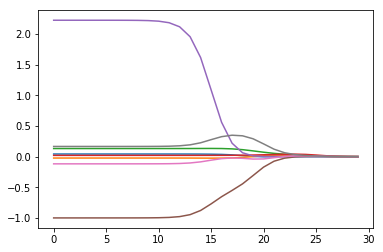

In [32]:
# lambda 较小时，ws保持原有值，lambda最大时，ws全部收敛到0
# 通过遍历不同lambda下的误差函数求最优lambda
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(ridgeWeights)
plt.show()

In [47]:
# 从不同lambda中挑选误差最小的最优解
def bestRidge(xArr,yArr,ridgeWeights):
    xMat = np.mat(xArr)
    yMat = np.mat(yArr).T
    xMean = np.mean(xMat,0) # 压缩成一个行
    yMean = np.mean(yMat,0) 
    xVar = np.var(xMat,0) # 方差
    xMat = (xMat - xMean)/xVar  # 为什么一个是归一化，一个没有彻底归一化？？？？
    yMat = yMat - yMean
    numTestPts = np.shape(ridgeWeights)[0] # 尝试的次数
    yHat = np.mat(np.zeros((numTestPts ,np.shape(yMat)[0])))# 预测结果矩阵
    errors = np.zeros((numTestPts,1))
    lowestIndex = 0
    lowestLambda = 0
    lowestError = np.inf
    for i in range(numTestPts):
        yHat[i,:] = (xMat*ridgeWeights[i,:].T).T
        errors[i,:] = ressError(yHat[i,:].T,yMat)
        if errors[i,:] < lowestError:
            lowestError = errors[i,:]
            lowestLambda = ridgeWeights[i,:]
            lowestIndex = i
        print(errors[i,:])
    return errors,lowestError,lowestLambda,ridgeWeights[lowestIndex,:]

[ 20494.55218986]
[ 20494.55218986]
[ 20494.55218986]
[ 20494.55218989]
[ 20494.55219008]
[ 20494.55219152]
[ 20494.55220212]
[ 20494.55228044]
[ 20494.55285844]
[ 20494.5571149]
[ 20494.58827956]
[ 20494.81293694]
[ 20496.36703624]
[ 20506.04803989]
[ 20553.40864041]
[ 20700.08222636]
[ 20941.89989275]
[ 21179.47710157]
[ 21473.69077461]
[ 22184.83175692]
[ 23668.29337342]
[ 25587.26188186]
[ 27140.68123588]
[ 28169.04231816]
[ 29386.15102311]
[ 32084.60763709]
[ 36317.05826729]
[ 39966.62318889]
[ 41981.9205655]
[ 42859.6064519]


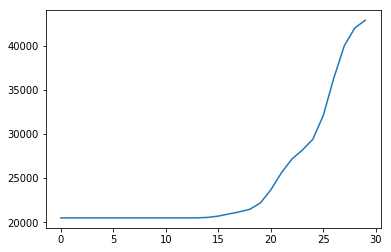

In [48]:
# 这个结果有些尴尬，不过训练集数量远大于特征数量，所以
errors,lowestError,lowestLambda,Weights = bestRidge(xArr,yArr,ridgeWeights)
errorFig = plt.figure()
errorAx = errorFig.add_subplot(111)
errorAx.plot(errors)
plt.show()

# step regression 逐步回归

# Forward-Stagewise Regression 前向分段 逐步回归

In [11]:
# 梯度下降也好，前向分段逐步回归也好，都是为了不解矩阵方程的替代方案
# 贪心算法：使用尝试的方法。使每一次的迭代误差最小
# 最大的优势在于能帮助人们理解数据特征的影响，然后优化模型！！！
# 迭代次数
# 归一化，否则步长容易不匹配
# 每次迭代都遍历整个特征，对于每个特征都加上或者减去一个很小的步长，然后比较误差大小，挑选误差最小的
# 注意每次遍历更改变量需要不直接更改原有变量，只有挑选出最优解在更改全局变量
# 每次移动步长，都是在全局变量的副本上操作，找到最优解再放到零时变量中，最后再将该次迭代中的最优解放到全局中去

def stageWise(xArr,yArr,eps = 0.01,numIt = 100):
    xMat = np.mat(xArr)
    yMat = np.mat(yArr).T
    xMean = np.mean(xArr,0)
    yMean = np.mean(yArr,0)
    xVar = np.var(xArr,0)
    xMat = (xMat-xMean)/xVar
    yMat = yMat - yMean # 为什么y不做完整的归一化？？？
    m,n = np.shape(xMat)
    retWetMat = np.zeros((numIt,n))
    ws = np.zeros((n,1))
    wsTest = ws.copy()
    wsMax = ws.copy()
    for i in range(numIt):
        print(ws.T)
        lowestError = np.inf
        for j in range(n):
            for sign in [-1,1]: # 对于加减的特殊写法
                wsTest = ws.copy()
                wsTest[j] += eps*sign         #   加或者减一个很小的偏差
                yTest = xMat * wsTest
                rssE = ressError(yTest,yMat)
                if rssE < lowestError:
                    lowestError = rssE
                    wsMax = wsTest
        ws = wsMax.copy()
        retWetMat[i,:] = ws.T
    return retWetMat         

In [70]:
# 分析输出结果：
# w1 w6 始终为0，这是无关特征
# 系数在后期已经饱和，在一定值范围内波动，这是步长太大的缘故
retWetMat  = stageWise(xArr,yArr,0.01,200)
retWetMat

[[ 0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.    0.    0.    0.01  0.    0.    0.    0.  ]]
[[ 0.    0.    0.    0.02  0.    0.    0.    0.  ]]
[[ 0.    0.    0.    0.03  0.    0.    0.    0.  ]]
[[ 0.    0.    0.    0.04  0.    0.    0.    0.  ]]
[[ 0.    0.    0.    0.05  0.    0.    0.    0.  ]]
[[ 0.    0.    0.    0.06  0.    0.    0.    0.  ]]
[[ 0.    0.    0.01  0.06  0.    0.    0.    0.  ]]
[[ 0.    0.    0.01  0.06  0.    0.    0.    0.01]]
[[ 0.    0.    0.01  0.06  0.    0.    0.    0.02]]
[[ 0.    0.    0.01  0.06  0.    0.    0.    0.03]]
[[ 0.    0.    0.01  0.06  0.    0.    0.    0.04]]
[[ 0.    0.    0.01  0.06  0.    0.    0.    0.05]]
[[ 0.    0.    0.01  0.06  0.    0.    0.    0.06]]
[[ 0.    0.    0.01  0.06  0.    0.    0.    0.07]]
[[ 0.    0.    0.01  0.06  0.    0.    0.    0.08]]
[[ 0.    0.    0.01  0.05  0.    0.    0.    0.08]]
[[ 0.    0.    0.01  0.05  0.    0.    0.    0.09]]
[[ 0.    0.    0.01  0.05  0.    0.    0.    0.1 ]]
[[ 0.    0.    0.01  0.05  0

array([[ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       ..., 
       [ 0.05,  0.  ,  0.09, ..., -0.64,  0.  ,  0.36],
       [ 0.04,  0.  ,  0.09, ..., -0.64,  0.  ,  0.36],
       [ 0.05,  0.  ,  0.09, ..., -0.64,  0.  ,  0.36]])

In [91]:
# 这里的数据没有分训练集测试集，归一化使用的参数训练测试时均相同
def test(retWetMat,k):   
    xMat = np.mat(xArr)
    yMat = np.mat(yArr).T
    xMean = np.mean(xArr,0)
    yMean = np.mean(yArr,0)
    xVar = np.var(xArr,0)
    xMat = (xMat-xMean)/xVar
    yMat = yMat - yMean
    m,n = np.shape(xMat)
    yHat = xMat*(np.mat(retWetMat[k,:]).T)
    return ressError(yHat,yMat)

40059.6071764
37186.2052344
34790.4247702
32872.2657837
31431.728275
30468.8122439
29958.4986434
29524.3061557
29133.2361081
28785.2885007
28480.4633335
28218.7606064
28000.1803196
27824.7224729
27692.3870664
27549.0841289
27342.5718987
27179.1821086
27058.9147587
26932.9301822
26823.9060601
26699.0222161
26583.0890813
26477.4582103
26354.6160628
26248.7343696
26138.4870046
26025.6962987
25929.8660472
25815.0021881
25712.2629239
25616.6520379
25507.0037609
25414.3159384
25314.0885583
25214.491723
25131.8553422
25027.011468
24937.4660744
24851.8751733
24755.420767
24675.9268151
24585.7194199
24499.3164552
24428.3620331
24335.0500557
24258.6985328
24183.1276165
24099.8670809
24033.5669996
23953.3795893
23880.1704953
23819.236058
23739.1179513
23675.960299
23610.4093677
23540.3427026
23487.236492
23415.9317121
23332.098467
23177.8138031
23099.8691539
23041.8414091
22983.149733
22918.2129755
22870.2366724
22806.9285022
22752.0431863
22707.9879892
22646.1936606
22601.3597865
22547.6753447
2

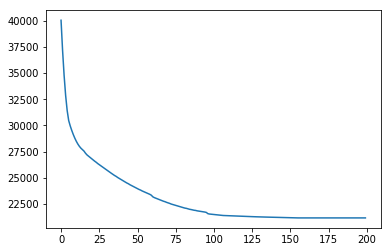

In [106]:
# 简化版测试算法
# 到后期，误差收敛到一定值
arr = np.zeros(200)
for i in range(200):
    arr[i] = test(retWetMat,i)
    print(arr[i])
arr.min()
errorFig = plt.figure()
errorAx = errorFig.add_subplot(111)
errorAx.plot(arr)
plt.show()

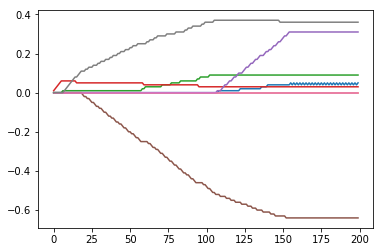

In [107]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(retWetMat)
plt.show()

In [110]:
# 使用更小的步长，解决震荡问题
retWetMat  = stageWise(xArr,yArr,0.005,1000)

[[ 0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.     0.     0.     0.005  0.     0.     0.     0.   ]]
[[ 0.    0.    0.    0.01  0.    0.    0.    0.  ]]
[[ 0.     0.     0.     0.015  0.     0.     0.     0.   ]]
[[ 0.    0.    0.    0.02  0.    0.    0.    0.  ]]
[[ 0.     0.     0.     0.025  0.     0.     0.     0.   ]]
[[ 0.    0.    0.    0.03  0.    0.    0.    0.  ]]
[[ 0.     0.     0.     0.035  0.     0.     0.     0.   ]]
[[ 0.    0.    0.    0.04  0.    0.    0.    0.  ]]
[[ 0.     0.     0.     0.045  0.     0.     0.     0.   ]]
[[ 0.    0.    0.    0.05  0.    0.    0.    0.  ]]
[[ 0.     0.     0.     0.055  0.     0.     0.     0.   ]]
[[ 0.    0.    0.    0.06  0.    0.    0.    0.  ]]
[[ 0.     0.     0.     0.065  0.     0.     0.     0.   ]]
[[ 0.     0.     0.005  0.065  0.     0.     0.     0.   ]]
[[ 0.     0.     0.005  0.065  0.     0.     0.     0.005]]
[[ 0.     0.     0.005  0.065  0.     0.     0.     0.01 ]]
[[ 0.     0.     0.005  0.065  0.     0.     0.     

[[ 0.     0.     0.055  0.035  0.    -0.355  0.     0.305]]
[[ 0.     0.     0.055  0.035  0.    -0.36   0.     0.305]]
[[ 0.     0.     0.055  0.035  0.    -0.36   0.     0.31 ]]
[[ 0.     0.     0.055  0.035  0.    -0.365  0.     0.31 ]]
[[ 0.     0.     0.055  0.035  0.    -0.37   0.     0.31 ]]
[[ 0.     0.     0.06   0.035  0.    -0.37   0.     0.31 ]]
[[ 0.     0.     0.06   0.035  0.    -0.375  0.     0.31 ]]
[[ 0.     0.     0.06   0.035  0.    -0.38   0.     0.31 ]]
[[ 0.     0.     0.06   0.035  0.    -0.38   0.     0.315]]
[[ 0.     0.     0.06   0.035  0.    -0.385  0.     0.315]]
[[ 0.     0.     0.06   0.035  0.    -0.39   0.     0.315]]
[[ 0.     0.     0.065  0.035  0.    -0.39   0.     0.315]]
[[ 0.     0.     0.065  0.035  0.    -0.395  0.     0.315]]
[[ 0.     0.     0.065  0.035  0.    -0.4    0.     0.315]]
[[ 0.     0.     0.065  0.035  0.    -0.4    0.     0.32 ]]
[[ 0.     0.     0.065  0.035  0.    -0.405  0.     0.32 ]]
[[ 0.     0.     0.065  0.035  0.    -0.

[[ 0.025  0.     0.1    0.025  0.28  -0.625 -0.005  0.365]]
[[ 0.025  0.     0.1    0.025  0.285 -0.625 -0.005  0.365]]
[[ 0.025  0.     0.1    0.025  0.285 -0.625 -0.01   0.365]]
[[ 0.025  0.     0.1    0.025  0.29  -0.625 -0.01   0.365]]
[[ 0.025  0.     0.1    0.025  0.295 -0.625 -0.01   0.365]]
[[ 0.025  0.     0.1    0.025  0.3   -0.625 -0.01   0.365]]
[[ 0.025  0.     0.1    0.025  0.305 -0.625 -0.01   0.365]]
[[ 0.025  0.     0.1    0.025  0.305 -0.63  -0.01   0.365]]
[[ 0.025  0.     0.1    0.025  0.31  -0.63  -0.01   0.365]]
[[ 0.025  0.     0.1    0.025  0.315 -0.63  -0.01   0.365]]
[[ 0.025  0.     0.1    0.025  0.315 -0.63  -0.01   0.36 ]]
[[ 0.025  0.     0.1    0.025  0.32  -0.63  -0.01   0.36 ]]
[[ 0.025  0.     0.1    0.025  0.325 -0.63  -0.01   0.36 ]]
[[ 0.025  0.     0.1    0.025  0.33  -0.63  -0.01   0.36 ]]
[[ 0.025  0.     0.1    0.025  0.33  -0.635 -0.01   0.36 ]]
[[ 0.025  0.     0.1    0.025  0.335 -0.635 -0.01   0.36 ]]
[[ 0.025  0.     0.1    0.025  0.34  -0.

[[ 0.035  0.     0.105  0.025  0.9   -0.75  -0.04   0.3  ]]
[[ 0.035  0.     0.105  0.025  0.9   -0.755 -0.04   0.3  ]]
[[ 0.035  0.     0.105  0.025  0.905 -0.755 -0.04   0.3  ]]
[[ 0.035  0.     0.105  0.025  0.91  -0.755 -0.04   0.3  ]]
[[ 0.04   0.     0.105  0.025  0.91  -0.755 -0.04   0.3  ]]
[[ 0.04   0.     0.105  0.025  0.915 -0.755 -0.04   0.3  ]]
[[ 0.04   0.     0.105  0.025  0.915 -0.755 -0.04   0.295]]
[[ 0.04   0.     0.105  0.025  0.92  -0.755 -0.04   0.295]]
[[ 0.04   0.     0.105  0.025  0.925 -0.755 -0.04   0.295]]
[[ 0.04   0.     0.105  0.025  0.93  -0.755 -0.04   0.295]]
[[ 0.04   0.     0.105  0.025  0.93  -0.76  -0.04   0.295]]
[[ 0.04   0.     0.105  0.025  0.935 -0.76  -0.04   0.295]]
[[ 0.04   0.     0.105  0.025  0.94  -0.76  -0.04   0.295]]
[[ 0.04   0.     0.105  0.025  0.94  -0.765 -0.04   0.295]]
[[ 0.04   0.     0.105  0.025  0.945 -0.765 -0.04   0.295]]
[[ 0.04   0.     0.105  0.025  0.95  -0.765 -0.04   0.295]]
[[ 0.04   0.     0.105  0.025  0.95  -0.

[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.

[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.

41675.4162015
40059.6071764
38563.2035207
37186.2052344
35928.6123176
34790.4247702
33771.6425922
32872.2657837
32092.2943446
31431.728275
30890.5675747
30468.8122439
30166.4622826
29942.656075
29735.8040871
29539.7327092
29354.4419413
29179.9317835
29016.2022357
28863.253298
28721.0849703
28589.6972527
28469.0901451
28359.2636476
28260.2177601
28171.9524826
28080.448438
27973.6389546
27877.6100813
27792.361818
27717.8941647
27628.4962256
27535.4843664
27453.2531173
27381.8024782
27321.1324491
27233.8406155
27154.6263805
27086.1927556
27028.5397407
26965.9303968
26907.5611665
26848.7540281
26788.6575447
26732.8011748
26672.8399129
26615.2562898
26560.1082712
26500.7973949
26445.7266323
26389.4244901
26332.6264743
26280.0685721
26222.6123064
26168.327151
26115.6841286
26058.2503765
25987.0631481
25926.6565298
25876.1469932
25820.5536182
25768.3168284
25717.5366966
25663.5726537
25613.8487244
25561.9144691
25510.4632866
25463.2522177
25410.1638389
25361.2255168
25312.9503812
25262.284806

20652.1271921
20652.2227567
20652.1271921
20652.2227567
20652.1271921
20652.2227567
20652.1271921
20652.2227567
20652.1271921
20652.2227567
20652.1271921
20652.2227567
20652.1271921
20652.2227567
20652.1271921
20652.2227567
20652.1271921
20652.2227567
20652.1271921
20652.2227567
20652.1271921
20652.2227567
20652.1271921
20652.2227567
20652.1271921
20652.2227567
20652.1271921
20652.2227567
20652.1271921
20652.2227567
20652.1271921
20652.2227567
20652.1271921
20652.2227567
20652.1271921
20652.2227567
20652.1271921
20652.2227567
20652.1271921
20652.2227567
20652.1271921
20652.2227567
20652.1271921
20652.2227567
20652.1271921
20652.2227567
20652.1271921
20652.2227567
20652.1271921
20652.2227567
20652.1271921
20652.2227567
20652.1271921
20652.2227567
20652.1271921
20652.2227567
20652.1271921
20652.2227567
20652.1271921
20652.2227567
20652.1271921
20652.2227567
20652.1271921
20652.2227567
20652.1271921
20652.2227567
20652.1271921
20652.2227567
20652.1271921
20652.2227567
20652.1271921
20652.

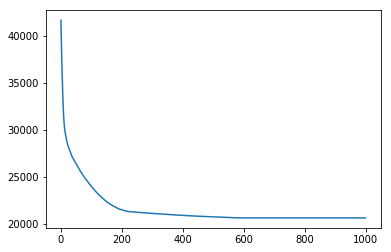

In [112]:
# 到后期，误差收敛到一定值
arr = np.zeros(1000)
for i in range(1000):
    arr[i] = test(retWetMat,i)
    print(arr[i])
arr.min()
errorFig = plt.figure()
errorAx = errorFig.add_subplot(111)
errorAx.plot(arr)
plt.show()

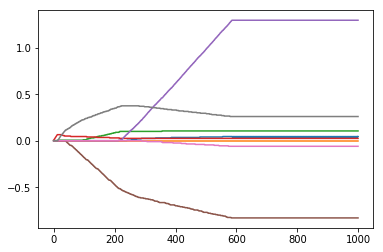

In [111]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(retWetMat)
plt.show()

In [49]:
# 缩减法结合交叉验证寻找最佳回归系数
# numVal 交叉验证折数
def crossValidation(xArr,yArr,numVal = 10):
    m = len(yArr)
    indexList = list(range(m))
    errorMat = np.zeros((numVal,30))
    for i in range(numVal):
        trainX = []
        trainY = []
        testX = []
        testY = []
        np.random.shuffle(indexList)             # 随机选取训练集测试集
        for j in range(m):
            if j < 0.9*m:
                trainX.append(xArr[indexList[j]])
                trainY.append(yArr[indexList[j]])
            else:
                testX.append(xArr[indexList[j]])
                testY.append(yArr[indexList[j]])
        wMat = ridgeTest(trainX,trainY)
        for k in range(30):
            trainXMat = np.mat(trainX) # 使用训练数据对测试数据进行归一化处理
            trainXMean = np.mean(trainXMat,0)
            trainXVar = np.var(trainXMat,0)
            trainYMean = np.mean(np.mat(trainY).T,0)
            testXMat = (np.mat(testX)-trainXMean)/trainXVar
            yEst = testXMat*np.mat(wMat[k,:]).T+trainYMean
            errorMat[i,k] = ressError(yEst,np.mat(testY).T)
            print(errorMat[i,k])
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.plot(errorMat[i,:])
        plt.show()
    meanErrors = np.mean(errorMat,0) # 10折交叉中，相同迭代编号的求平均，变成一个单行向量
    minMean = float(np.min(meanErrors))
    bestWeights = wMat[np.nonzero(meanErrors == minMean)] # 特殊的取最小值方法
    xMat = np.mat(xArr)
    yMat = np.mat(yArr).T
    xMean = np.mean(xArr,0)
    yMean = np.mean(yArr,0)
    xVar = np.var(xArr,0)
    unReg = bestWeights/xVar   # 相当于将(X-meanX)/varX*weights+meanY -> X*weights  -meanX*weights/varX + meanY 
    print('best model:'+str(unReg))
    print('with constant term:')
    print(-1*np.sum(np.multiply(xMean,unReg))+yMean)   

2371.67895989
2371.67897806
2371.67902745
2371.6791617
2371.67952665
2371.6805188
2371.68321651
2371.69055553
2371.71054819
2371.76521071
2371.91610028
2372.3424915
2373.60718197
2377.59542418
2389.83194484
2418.33733951
2458.89670331
2499.20250397
2550.20943349
2646.01233528
2801.75596838
2972.67458137
3098.88315663
3189.9724156
3333.60967727
3644.69110772
4076.20131501
4415.59516234
4593.84141467
4669.75256432


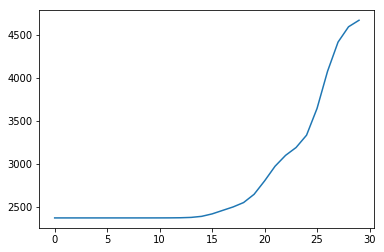

1932.33060261
1932.33059103
1932.33055955
1932.33047401
1932.33024148
1932.32960961
1932.32789332
1932.32323776
1932.31065496
1932.27698316
1932.18933089
1931.97869751
1931.59138892
1931.59771816
1935.66308668
1951.38738819
1976.53849186
1997.81389738
2021.313158
2086.76875127
2231.99215362
2412.44026392
2537.53021594
2601.630737
2693.92592001
2936.80839066
3306.10535619
3607.23777278
3767.6150239
3836.27850871


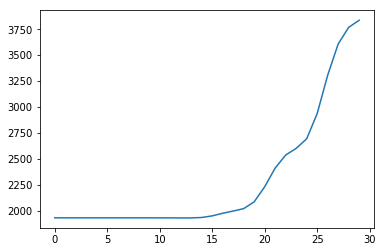

1961.98731115
1961.98731529
1961.98732655
1961.98735715
1961.98744034
1961.98766658
1961.98828237
1961.98996208
1961.99457099
1962.00741524
1962.04462974
1962.16211873
1962.58977702
1964.35058544
1971.12903709
1988.98787607
2014.23129424
2033.83284489
2053.16168825
2108.97857061
2237.91698056
2405.83473429
2539.79020387
2639.99305513
2792.24639448
3109.19134534
3541.2452035
3878.51274109
4055.07691834
4130.17595408


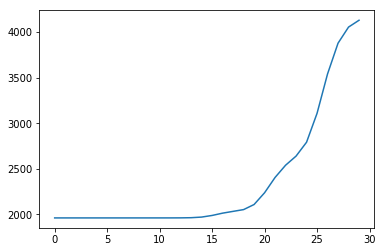

2119.95559035
2119.95561116
2119.95566772
2119.95582146
2119.95623937
2119.95737541
2119.96046377
2119.96886083
2119.99170125
2120.05389693
2120.22375005
2120.69093761
2121.99507461
2125.69190059
2135.71989893
2157.27750201
2187.43117544
2218.92276138
2263.88613081
2356.38588433
2514.16468958
2691.74354217
2824.21071118
2917.2898951
3055.06812883
3355.83559652
3781.3502943
4119.78978326
4298.43441499
4374.67103729


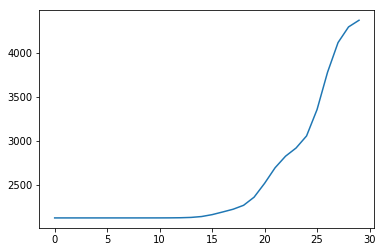

1837.28888773
1837.28891218
1837.28897865
1837.28915932
1837.28965045
1837.29098554
1837.2946152
1837.30448537
1837.33134266
1837.40454928
1837.6050003
1838.16005101
1839.73327201
1844.31496415
1857.09114731
1884.50985876
1920.20414409
1949.47921825
1981.1715938
2059.09858603
2224.2234935
2430.57419061
2584.31793463
2676.90690744
2792.04538421
3046.51419607
3414.5051012
3709.56730503
3865.69928007
3932.37888675


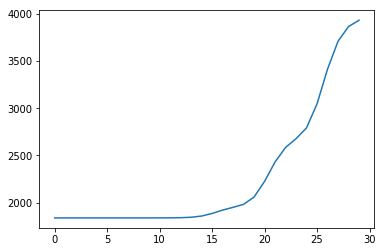

2306.56671494
2306.56672771
2306.56676242
2306.56685679
2306.5671133
2306.56781066
2306.56970675
2306.57486449
2306.58891146
2306.62729171
2306.73304873
2307.03061114
2307.90526319
2310.62749028
2318.9060383
2338.23014145
2365.70500196
2392.47917939
2429.39538687
2516.39337385
2686.86999734
2894.30656988
3052.25092373
3164.97904745
3333.17879539
3678.33077911
4143.41347045
4504.46444842
4693.0684938
4773.22358679


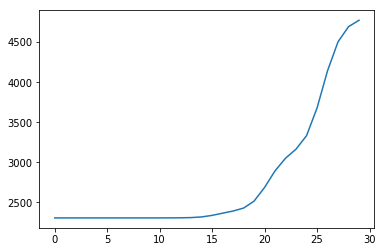

2072.27657213
2072.27657273
2072.27657433
2072.27657871
2072.27659061
2072.27662308
2072.27671217
2072.27696046
2072.27768038
2072.27996836
2072.28860035
2072.32924032
2072.55451421
2073.81605008
2079.5998288
2096.53093758
2123.55878045
2151.96056334
2192.46128708
2286.28958702
2469.05107309
2693.33154017
2867.15812573
2988.46426881
3154.72494287
3495.47951158
3964.8327319
4334.34024915
4528.65078129
4611.45919299


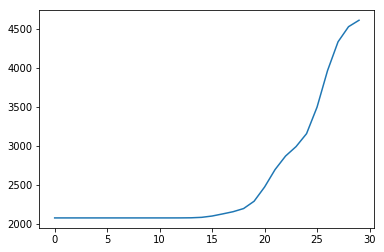

2525.47147304
2525.47146026
2525.47142554
2525.47133115
2525.4710746
2525.47037742
2525.4684837
2525.46334652
2525.4494594
2525.41227799
2525.31534725
2525.0813563
2524.64304088
2524.58206078
2528.74037675
2545.10992867
2571.38164007
2594.18450699
2622.90369103
2705.13279781
2879.16991587
3089.34660685
3245.00334568
3346.8964493
3486.21850808
3782.90321282
4198.10111944
4526.32078107
4699.04746886
4772.66327112


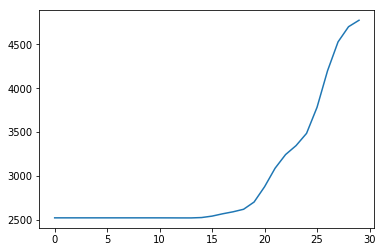

1860.00759873
1860.00750809
1860.00726173
1860.00659204
1860.00477169
1859.99982392
1859.98637779
1859.94985181
1859.85074375
1859.58266373
1858.86362019
1856.97844632
1852.32771471
1842.53645677
1828.70495926
1822.83095566
1833.06786891
1849.06394359
1870.75344468
1921.91816796
2024.7165347
2156.12914254
2264.39572789
2352.23869125
2504.51617954
2847.28383519
3333.00522903
3719.86691351
3924.33634429
4011.65455078


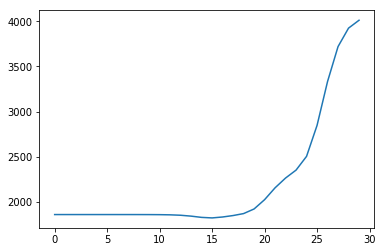

2498.35669362
2498.35663865
2498.35648922
2498.35608305
2498.35497899
2498.35197817
2498.34382337
2498.32167325
2498.26158768
2498.0991759
2497.6643995
2496.53060127
2493.77574392
2488.24087573
2481.75288733
2483.63663414
2497.46987671
2511.60372058
2525.9923007
2566.98312313
2668.93758094
2816.5997339
2946.3509516
3063.25597004
3271.10037568
3689.67759951
4234.3644565
4649.8561271
4865.36014275
4956.70144927


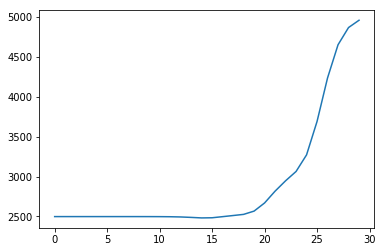

best model:[[  0.075318    -1.96597675  13.61163615  10.35551059   9.20603416
  -20.14277017 -10.33312233   9.38675085]]
with constant term:
3.19663915258


In [50]:
crossValidation(xArr,yArr,numVal = 10)

In [52]:
# 缩减法结合交叉验证寻找最佳回归系数
# numVal 交叉验证折数
def crossValidation2(xArr,yArr,numVal = 10):
    m = len(yArr)
    indexList = list(range(m))
    errorMat = np.zeros((numVal,1000))
    for i in range(numVal):
        trainX = []
        trainY = []
        testX = []
        testY = []
        np.random.shuffle(indexList)             # 随机选取训练集测试集
        for j in range(m):
            if j < 0.9*m:
                trainX.append(xArr[indexList[j]])
                trainY.append(yArr[indexList[j]])
            else:
                testX.append(xArr[indexList[j]])
                testY.append(yArr[indexList[j]])
        wMat = stageWise(xArr,yArr,0.005,1000)
        for k in range(1000):
            trainXMat = np.mat(trainX) # 使用训练数据对测试数据进行归一化处理
            trainXMean = np.mean(trainXMat,0)
            trainXVar = np.var(trainXMat,0)
            trainYMean = np.mean(np.mat(trainY).T,0)
            testXMat = (np.mat(testX)-trainXMean)/trainXVar
            yEst = testXMat*np.mat(wMat[k,:]).T+trainYMean # 这里加和在trainY中减，都是一个道理
            errorMat[i,k] = ressError(yEst,np.mat(testY).T)
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.plot(errorMat[i,:])
        plt.show()
    meanErrors = np.mean(errorMat,0) # 10折交叉中，相同迭代编号的求平均，变成一个单行向量
    minMean = float(np.min(meanErrors))
    bestWeights = wMat[np.nonzero(meanErrors == minMean)] # 特殊的取最小值方法
    xMat = np.mat(xArr)
    yMat = np.mat(yArr).T
    xMean = np.mean(xArr,0)
    yMean = np.mean(yArr,0)
    xVar = np.var(xArr,0)
    unReg = bestWeights/xVar   # 相当于将(X-meanX)/varX*weights+meanY -> X*weights  -meanX*weights/varX + meanY 
    print('best model:'+str(unReg))
    print('with constant term:')
    print(-1*np.sum(np.multiply(xMean,unReg))+yMean)

[[ 0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.     0.     0.     0.005  0.     0.     0.     0.   ]]
[[ 0.    0.    0.    0.01  0.    0.    0.    0.  ]]
[[ 0.     0.     0.     0.015  0.     0.     0.     0.   ]]
[[ 0.    0.    0.    0.02  0.    0.    0.    0.  ]]
[[ 0.     0.     0.     0.025  0.     0.     0.     0.   ]]
[[ 0.    0.    0.    0.03  0.    0.    0.    0.  ]]
[[ 0.     0.     0.     0.035  0.     0.     0.     0.   ]]
[[ 0.    0.    0.    0.04  0.    0.    0.    0.  ]]
[[ 0.     0.     0.     0.045  0.     0.     0.     0.   ]]
[[ 0.    0.    0.    0.05  0.    0.    0.    0.  ]]
[[ 0.     0.     0.     0.055  0.     0.     0.     0.   ]]
[[ 0.    0.    0.    0.06  0.    0.    0.    0.  ]]
[[ 0.     0.     0.     0.065  0.     0.     0.     0.   ]]
[[ 0.     0.     0.005  0.065  0.     0.     0.     0.   ]]
[[ 0.     0.     0.005  0.065  0.     0.     0.     0.005]]
[[ 0.     0.     0.005  0.065  0.     0.     0.     0.01 ]]
[[ 0.     0.     0.005  0.065  0.     0.     0.     

[[ 0.     0.     0.05   0.035  0.    -0.335  0.     0.3  ]]
[[ 0.     0.     0.05   0.035  0.    -0.34   0.     0.3  ]]
[[ 0.     0.     0.05   0.035  0.    -0.345  0.     0.3  ]]
[[ 0.     0.     0.055  0.035  0.    -0.345  0.     0.3  ]]
[[ 0.     0.     0.055  0.035  0.    -0.35   0.     0.3  ]]
[[ 0.     0.     0.055  0.035  0.    -0.355  0.     0.3  ]]
[[ 0.     0.     0.055  0.035  0.    -0.355  0.     0.305]]
[[ 0.     0.     0.055  0.035  0.    -0.36   0.     0.305]]
[[ 0.     0.     0.055  0.035  0.    -0.36   0.     0.31 ]]
[[ 0.     0.     0.055  0.035  0.    -0.365  0.     0.31 ]]
[[ 0.     0.     0.055  0.035  0.    -0.37   0.     0.31 ]]
[[ 0.     0.     0.06   0.035  0.    -0.37   0.     0.31 ]]
[[ 0.     0.     0.06   0.035  0.    -0.375  0.     0.31 ]]
[[ 0.     0.     0.06   0.035  0.    -0.38   0.     0.31 ]]
[[ 0.     0.     0.06   0.035  0.    -0.38   0.     0.315]]
[[ 0.     0.     0.06   0.035  0.    -0.385  0.     0.315]]
[[ 0.     0.     0.06   0.035  0.    -0.

[[ 0.025  0.     0.1    0.025  0.37  -0.64  -0.01   0.355]]
[[ 0.025  0.     0.1    0.025  0.37  -0.645 -0.01   0.355]]
[[ 0.025  0.     0.1    0.025  0.375 -0.645 -0.01   0.355]]
[[ 0.025  0.     0.1    0.025  0.38  -0.645 -0.01   0.355]]
[[ 0.025  0.     0.1    0.025  0.38  -0.65  -0.01   0.355]]
[[ 0.025  0.     0.1    0.025  0.385 -0.65  -0.01   0.355]]
[[ 0.025  0.     0.1    0.025  0.39  -0.65  -0.01   0.355]]
[[ 0.03   0.     0.1    0.025  0.39  -0.65  -0.01   0.355]]
[[ 0.03   0.     0.1    0.025  0.395 -0.65  -0.01   0.355]]
[[ 0.03   0.     0.1    0.025  0.395 -0.65  -0.01   0.35 ]]
[[ 0.03   0.     0.1    0.025  0.4   -0.65  -0.01   0.35 ]]
[[ 0.03   0.     0.1    0.025  0.405 -0.65  -0.01   0.35 ]]
[[ 0.03   0.     0.1    0.025  0.41  -0.65  -0.01   0.35 ]]
[[ 0.03   0.     0.1    0.025  0.41  -0.655 -0.01   0.35 ]]
[[ 0.03   0.     0.1    0.025  0.415 -0.655 -0.01   0.35 ]]
[[ 0.03   0.     0.1    0.025  0.42  -0.655 -0.01   0.35 ]]
[[ 0.03   0.     0.1    0.025  0.42  -0.

[[ 0.04   0.     0.105  0.025  0.95  -0.77  -0.04   0.295]]
[[ 0.04   0.     0.105  0.025  0.955 -0.77  -0.04   0.295]]
[[ 0.04   0.     0.105  0.025  0.96  -0.77  -0.04   0.295]]
[[ 0.04   0.     0.105  0.025  0.965 -0.77  -0.04   0.295]]
[[ 0.04   0.     0.105  0.025  0.965 -0.77  -0.045  0.295]]
[[ 0.04   0.     0.105  0.025  0.97  -0.77  -0.045  0.295]]
[[ 0.04   0.     0.105  0.025  0.975 -0.77  -0.045  0.295]]
[[ 0.04   0.     0.105  0.025  0.98  -0.77  -0.045  0.295]]
[[ 0.04   0.     0.105  0.025  0.985 -0.77  -0.045  0.295]]
[[ 0.04   0.     0.105  0.025  0.985 -0.77  -0.045  0.29 ]]
[[ 0.04   0.     0.105  0.025  0.99  -0.77  -0.045  0.29 ]]
[[ 0.04   0.     0.105  0.025  0.995 -0.77  -0.045  0.29 ]]
[[ 0.04   0.     0.105  0.025  1.    -0.77  -0.045  0.29 ]]
[[ 0.04   0.     0.105  0.025  1.    -0.775 -0.045  0.29 ]]
[[ 0.04   0.     0.105  0.025  1.005 -0.775 -0.045  0.29 ]]
[[ 0.04   0.     0.105  0.025  1.01  -0.775 -0.045  0.29 ]]
[[ 0.04   0.     0.105  0.025  1.01  -0.

[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.

[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]


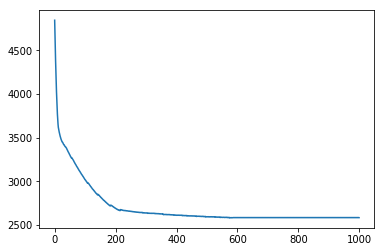

[[ 0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.     0.     0.     0.005  0.     0.     0.     0.   ]]
[[ 0.    0.    0.    0.01  0.    0.    0.    0.  ]]
[[ 0.     0.     0.     0.015  0.     0.     0.     0.   ]]
[[ 0.    0.    0.    0.02  0.    0.    0.    0.  ]]
[[ 0.     0.     0.     0.025  0.     0.     0.     0.   ]]
[[ 0.    0.    0.    0.03  0.    0.    0.    0.  ]]
[[ 0.     0.     0.     0.035  0.     0.     0.     0.   ]]
[[ 0.    0.    0.    0.04  0.    0.    0.    0.  ]]
[[ 0.     0.     0.     0.045  0.     0.     0.     0.   ]]
[[ 0.    0.    0.    0.05  0.    0.    0.    0.  ]]
[[ 0.     0.     0.     0.055  0.     0.     0.     0.   ]]
[[ 0.    0.    0.    0.06  0.    0.    0.    0.  ]]
[[ 0.     0.     0.     0.065  0.     0.     0.     0.   ]]
[[ 0.     0.     0.005  0.065  0.     0.     0.     0.   ]]
[[ 0.     0.     0.005  0.065  0.     0.     0.     0.005]]
[[ 0.     0.     0.005  0.065  0.     0.     0.     0.01 ]]
[[ 0.     0.     0.005  0.065  0.     0.     0.     

[[ 0.015  0.     0.1    0.025  0.13  -0.585  0.     0.375]]
[[ 0.015  0.     0.1    0.025  0.135 -0.585  0.     0.375]]
[[ 0.015  0.     0.1    0.025  0.14  -0.585  0.     0.375]]
[[ 0.015  0.     0.1    0.025  0.14  -0.59   0.     0.375]]
[[ 0.015  0.     0.1    0.025  0.145 -0.59   0.     0.375]]
[[ 0.015  0.     0.1    0.025  0.15  -0.59   0.     0.375]]
[[ 0.015  0.     0.1    0.025  0.15  -0.595  0.     0.375]]
[[ 0.015  0.     0.1    0.025  0.155 -0.595  0.     0.375]]
[[ 0.015  0.     0.1    0.025  0.16  -0.595  0.     0.375]]
[[ 0.015  0.     0.1    0.025  0.16  -0.6    0.     0.375]]
[[ 0.015  0.     0.1    0.025  0.165 -0.6    0.     0.375]]
[[ 0.015  0.     0.1    0.025  0.17  -0.6    0.     0.375]]
[[ 0.02   0.     0.1    0.025  0.17  -0.6    0.     0.375]]
[[ 0.02   0.     0.1    0.025  0.175 -0.6    0.     0.375]]
[[ 0.02   0.     0.1    0.025  0.175 -0.605  0.     0.375]]
[[ 0.02   0.     0.1    0.025  0.18  -0.605  0.     0.375]]
[[ 0.02   0.     0.1    0.025  0.185 -0.

[[ 0.035  0.     0.105  0.025  0.615 -0.695 -0.025  0.33 ]]
[[ 0.035  0.     0.105  0.025  0.615 -0.7   -0.025  0.33 ]]
[[ 0.035  0.     0.105  0.025  0.62  -0.7   -0.025  0.33 ]]
[[ 0.035  0.     0.105  0.025  0.625 -0.7   -0.025  0.33 ]]
[[ 0.035  0.     0.105  0.025  0.63  -0.7   -0.025  0.33 ]]
[[ 0.035  0.     0.105  0.025  0.63  -0.7   -0.025  0.325]]
[[ 0.035  0.     0.105  0.025  0.635 -0.7   -0.025  0.325]]
[[ 0.035  0.     0.105  0.025  0.64  -0.7   -0.025  0.325]]
[[ 0.035  0.     0.105  0.025  0.645 -0.7   -0.025  0.325]]
[[ 0.035  0.     0.105  0.025  0.645 -0.705 -0.025  0.325]]
[[ 0.035  0.     0.105  0.025  0.65  -0.705 -0.025  0.325]]
[[ 0.035  0.     0.105  0.025  0.655 -0.705 -0.025  0.325]]
[[ 0.035  0.     0.105  0.025  0.655 -0.705 -0.025  0.32 ]]
[[ 0.035  0.     0.105  0.025  0.66  -0.705 -0.025  0.32 ]]
[[ 0.035  0.     0.105  0.025  0.665 -0.705 -0.025  0.32 ]]
[[ 0.035  0.     0.105  0.025  0.67  -0.705 -0.025  0.32 ]]
[[ 0.035  0.     0.105  0.025  0.67  -0.

[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.

[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.

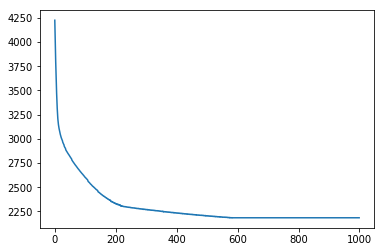

[[ 0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.     0.     0.     0.005  0.     0.     0.     0.   ]]
[[ 0.    0.    0.    0.01  0.    0.    0.    0.  ]]
[[ 0.     0.     0.     0.015  0.     0.     0.     0.   ]]
[[ 0.    0.    0.    0.02  0.    0.    0.    0.  ]]
[[ 0.     0.     0.     0.025  0.     0.     0.     0.   ]]
[[ 0.    0.    0.    0.03  0.    0.    0.    0.  ]]
[[ 0.     0.     0.     0.035  0.     0.     0.     0.   ]]
[[ 0.    0.    0.    0.04  0.    0.    0.    0.  ]]
[[ 0.     0.     0.     0.045  0.     0.     0.     0.   ]]
[[ 0.    0.    0.    0.05  0.    0.    0.    0.  ]]
[[ 0.     0.     0.     0.055  0.     0.     0.     0.   ]]
[[ 0.    0.    0.    0.06  0.    0.    0.    0.  ]]
[[ 0.     0.     0.     0.065  0.     0.     0.     0.   ]]
[[ 0.     0.     0.005  0.065  0.     0.     0.     0.   ]]
[[ 0.     0.     0.005  0.065  0.     0.     0.     0.005]]
[[ 0.     0.     0.005  0.065  0.     0.     0.     0.01 ]]
[[ 0.     0.     0.005  0.065  0.     0.     0.     

[[ 0.     0.     0.075  0.03   0.    -0.43   0.     0.34 ]]
[[ 0.     0.     0.075  0.03   0.    -0.435  0.     0.34 ]]
[[ 0.     0.     0.075  0.03   0.    -0.44   0.     0.34 ]]
[[ 0.    0.    0.08  0.03  0.   -0.44  0.    0.34]]
[[ 0.     0.     0.08   0.03   0.    -0.445  0.     0.34 ]]
[[ 0.    0.    0.08  0.03  0.   -0.45  0.    0.34]]
[[ 0.     0.     0.08   0.03   0.    -0.45   0.     0.345]]
[[ 0.     0.     0.08   0.03   0.    -0.455  0.     0.345]]
[[ 0.     0.     0.08   0.03   0.    -0.46   0.     0.345]]
[[ 0.     0.     0.085  0.03   0.    -0.46   0.     0.345]]
[[ 0.     0.     0.085  0.03   0.    -0.465  0.     0.345]]
[[ 0.     0.     0.085  0.03   0.    -0.47   0.     0.345]]
[[ 0.     0.     0.085  0.03   0.    -0.47   0.     0.35 ]]
[[ 0.     0.     0.085  0.03   0.    -0.475  0.     0.35 ]]
[[ 0.     0.     0.085  0.03   0.    -0.48   0.     0.35 ]]
[[ 0.    0.    0.09  0.03  0.   -0.48  0.    0.35]]
[[ 0.     0.     0.09   0.03   0.    -0.485  0.     0.35 ]]
[[ 0

[[ 0.03   0.     0.105  0.025  0.51  -0.675 -0.02   0.34 ]]
[[ 0.03   0.     0.105  0.025  0.515 -0.675 -0.02   0.34 ]]
[[ 0.03   0.     0.105  0.025  0.52  -0.675 -0.02   0.34 ]]
[[ 0.03   0.     0.105  0.025  0.52  -0.675 -0.02   0.335]]
[[ 0.03   0.     0.105  0.025  0.525 -0.675 -0.02   0.335]]
[[ 0.03   0.     0.105  0.025  0.53  -0.675 -0.02   0.335]]
[[ 0.03   0.     0.105  0.025  0.535 -0.675 -0.02   0.335]]
[[ 0.03   0.     0.105  0.025  0.535 -0.68  -0.02   0.335]]
[[ 0.03   0.     0.105  0.025  0.54  -0.68  -0.02   0.335]]
[[ 0.03   0.     0.105  0.025  0.545 -0.68  -0.02   0.335]]
[[ 0.03   0.     0.105  0.025  0.545 -0.685 -0.02   0.335]]
[[ 0.03   0.     0.105  0.025  0.55  -0.685 -0.02   0.335]]
[[ 0.03   0.     0.105  0.025  0.555 -0.685 -0.02   0.335]]
[[ 0.03   0.     0.105  0.025  0.555 -0.69  -0.02   0.335]]
[[ 0.03   0.     0.105  0.025  0.56  -0.69  -0.02   0.335]]
[[ 0.03   0.     0.105  0.025  0.565 -0.69  -0.02   0.335]]
[[ 0.035  0.     0.105  0.025  0.565 -0.

[[ 0.04   0.     0.105  0.025  1.175 -0.805 -0.055  0.27 ]]
[[ 0.04   0.     0.105  0.025  1.18  -0.805 -0.055  0.27 ]]
[[ 0.04   0.     0.105  0.025  1.185 -0.805 -0.055  0.27 ]]
[[ 0.045  0.     0.105  0.025  1.185 -0.805 -0.055  0.27 ]]
[[ 0.045  0.     0.105  0.025  1.185 -0.81  -0.055  0.27 ]]
[[ 0.045  0.     0.105  0.025  1.19  -0.81  -0.055  0.27 ]]
[[ 0.045  0.     0.105  0.025  1.195 -0.81  -0.055  0.27 ]]
[[ 0.045  0.     0.105  0.025  1.2   -0.81  -0.055  0.27 ]]
[[ 0.045  0.     0.105  0.025  1.2   -0.81  -0.055  0.265]]
[[ 0.045  0.     0.105  0.025  1.205 -0.81  -0.055  0.265]]
[[ 0.045  0.     0.105  0.025  1.21  -0.81  -0.055  0.265]]
[[ 0.045  0.     0.105  0.025  1.215 -0.81  -0.055  0.265]]
[[ 0.045  0.     0.105  0.025  1.215 -0.815 -0.055  0.265]]
[[ 0.045  0.     0.105  0.025  1.22  -0.815 -0.055  0.265]]
[[ 0.045  0.     0.105  0.025  1.225 -0.815 -0.055  0.265]]
[[ 0.045  0.     0.105  0.025  1.225 -0.82  -0.055  0.265]]
[[ 0.045  0.     0.105  0.025  1.23  -0.

[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.

[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.

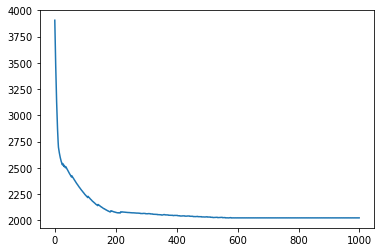

[[ 0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.     0.     0.     0.005  0.     0.     0.     0.   ]]
[[ 0.    0.    0.    0.01  0.    0.    0.    0.  ]]
[[ 0.     0.     0.     0.015  0.     0.     0.     0.   ]]
[[ 0.    0.    0.    0.02  0.    0.    0.    0.  ]]
[[ 0.     0.     0.     0.025  0.     0.     0.     0.   ]]
[[ 0.    0.    0.    0.03  0.    0.    0.    0.  ]]
[[ 0.     0.     0.     0.035  0.     0.     0.     0.   ]]
[[ 0.    0.    0.    0.04  0.    0.    0.    0.  ]]
[[ 0.     0.     0.     0.045  0.     0.     0.     0.   ]]
[[ 0.    0.    0.    0.05  0.    0.    0.    0.  ]]
[[ 0.     0.     0.     0.055  0.     0.     0.     0.   ]]
[[ 0.    0.    0.    0.06  0.    0.    0.    0.  ]]
[[ 0.     0.     0.     0.065  0.     0.     0.     0.   ]]
[[ 0.     0.     0.005  0.065  0.     0.     0.     0.   ]]
[[ 0.     0.     0.005  0.065  0.     0.     0.     0.005]]
[[ 0.     0.     0.005  0.065  0.     0.     0.     0.01 ]]
[[ 0.     0.     0.005  0.065  0.     0.     0.     

[[ 0.     0.     0.1    0.025  0.03  -0.54   0.     0.375]]
[[ 0.     0.     0.1    0.025  0.035 -0.54   0.     0.375]]
[[ 0.     0.     0.1    0.025  0.04  -0.54   0.     0.375]]
[[ 0.     0.     0.1    0.025  0.04  -0.545  0.     0.375]]
[[ 0.     0.     0.1    0.025  0.045 -0.545  0.     0.375]]
[[ 0.     0.     0.1    0.025  0.05  -0.545  0.     0.375]]
[[ 0.     0.     0.1    0.025  0.05  -0.55   0.     0.375]]
[[ 0.     0.     0.1    0.025  0.055 -0.55   0.     0.375]]
[[ 0.     0.     0.1    0.025  0.06  -0.55   0.     0.375]]
[[ 0.     0.     0.1    0.025  0.06  -0.555  0.     0.375]]
[[ 0.     0.     0.1    0.025  0.065 -0.555  0.     0.375]]
[[ 0.     0.     0.1    0.025  0.07  -0.555  0.     0.375]]
[[ 0.005  0.     0.1    0.025  0.07  -0.555  0.     0.375]]
[[ 0.005  0.     0.1    0.025  0.07  -0.56   0.     0.375]]
[[ 0.005  0.     0.1    0.025  0.075 -0.56   0.     0.375]]
[[ 0.005  0.     0.1    0.025  0.08  -0.56   0.     0.375]]
[[ 0.005  0.     0.1    0.025  0.085 -0.

[[ 0.04   0.     0.105  0.025  0.93  -0.755 -0.04   0.295]]
[[ 0.04   0.     0.105  0.025  0.93  -0.76  -0.04   0.295]]
[[ 0.04   0.     0.105  0.025  0.935 -0.76  -0.04   0.295]]
[[ 0.04   0.     0.105  0.025  0.94  -0.76  -0.04   0.295]]
[[ 0.04   0.     0.105  0.025  0.94  -0.765 -0.04   0.295]]
[[ 0.04   0.     0.105  0.025  0.945 -0.765 -0.04   0.295]]
[[ 0.04   0.     0.105  0.025  0.95  -0.765 -0.04   0.295]]
[[ 0.04   0.     0.105  0.025  0.95  -0.77  -0.04   0.295]]
[[ 0.04   0.     0.105  0.025  0.955 -0.77  -0.04   0.295]]
[[ 0.04   0.     0.105  0.025  0.96  -0.77  -0.04   0.295]]
[[ 0.04   0.     0.105  0.025  0.965 -0.77  -0.04   0.295]]
[[ 0.04   0.     0.105  0.025  0.965 -0.77  -0.045  0.295]]
[[ 0.04   0.     0.105  0.025  0.97  -0.77  -0.045  0.295]]
[[ 0.04   0.     0.105  0.025  0.975 -0.77  -0.045  0.295]]
[[ 0.04   0.     0.105  0.025  0.98  -0.77  -0.045  0.295]]
[[ 0.04   0.     0.105  0.025  0.985 -0.77  -0.045  0.295]]
[[ 0.04   0.     0.105  0.025  0.985 -0.

[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.

[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]


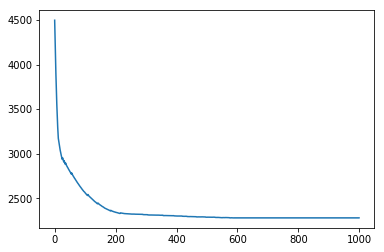

[[ 0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.     0.     0.     0.005  0.     0.     0.     0.   ]]
[[ 0.    0.    0.    0.01  0.    0.    0.    0.  ]]
[[ 0.     0.     0.     0.015  0.     0.     0.     0.   ]]
[[ 0.    0.    0.    0.02  0.    0.    0.    0.  ]]
[[ 0.     0.     0.     0.025  0.     0.     0.     0.   ]]
[[ 0.    0.    0.    0.03  0.    0.    0.    0.  ]]
[[ 0.     0.     0.     0.035  0.     0.     0.     0.   ]]
[[ 0.    0.    0.    0.04  0.    0.    0.    0.  ]]
[[ 0.     0.     0.     0.045  0.     0.     0.     0.   ]]
[[ 0.    0.    0.    0.05  0.    0.    0.    0.  ]]
[[ 0.     0.     0.     0.055  0.     0.     0.     0.   ]]
[[ 0.    0.    0.    0.06  0.    0.    0.    0.  ]]
[[ 0.     0.     0.     0.065  0.     0.     0.     0.   ]]
[[ 0.     0.     0.005  0.065  0.     0.     0.     0.   ]]
[[ 0.     0.     0.005  0.065  0.     0.     0.     0.005]]
[[ 0.     0.     0.005  0.065  0.     0.     0.     0.01 ]]
[[ 0.     0.     0.005  0.065  0.     0.     0.     

[[ 0.     0.     0.075  0.03   0.    -0.425  0.     0.335]]
[[ 0.     0.     0.075  0.03   0.    -0.43   0.     0.335]]
[[ 0.     0.     0.075  0.03   0.    -0.43   0.     0.34 ]]
[[ 0.     0.     0.075  0.03   0.    -0.435  0.     0.34 ]]
[[ 0.     0.     0.075  0.03   0.    -0.44   0.     0.34 ]]
[[ 0.    0.    0.08  0.03  0.   -0.44  0.    0.34]]
[[ 0.     0.     0.08   0.03   0.    -0.445  0.     0.34 ]]
[[ 0.    0.    0.08  0.03  0.   -0.45  0.    0.34]]
[[ 0.     0.     0.08   0.03   0.    -0.45   0.     0.345]]
[[ 0.     0.     0.08   0.03   0.    -0.455  0.     0.345]]
[[ 0.     0.     0.08   0.03   0.    -0.46   0.     0.345]]
[[ 0.     0.     0.085  0.03   0.    -0.46   0.     0.345]]
[[ 0.     0.     0.085  0.03   0.    -0.465  0.     0.345]]
[[ 0.     0.     0.085  0.03   0.    -0.47   0.     0.345]]
[[ 0.     0.     0.085  0.03   0.    -0.47   0.     0.35 ]]
[[ 0.     0.     0.085  0.03   0.    -0.475  0.     0.35 ]]
[[ 0.     0.     0.085  0.03   0.    -0.48   0.     0.35

[[ 0.03   0.     0.105  0.025  0.515 -0.675 -0.02   0.34 ]]
[[ 0.03   0.     0.105  0.025  0.52  -0.675 -0.02   0.34 ]]
[[ 0.03   0.     0.105  0.025  0.52  -0.675 -0.02   0.335]]
[[ 0.03   0.     0.105  0.025  0.525 -0.675 -0.02   0.335]]
[[ 0.03   0.     0.105  0.025  0.53  -0.675 -0.02   0.335]]
[[ 0.03   0.     0.105  0.025  0.535 -0.675 -0.02   0.335]]
[[ 0.03   0.     0.105  0.025  0.535 -0.68  -0.02   0.335]]
[[ 0.03   0.     0.105  0.025  0.54  -0.68  -0.02   0.335]]
[[ 0.03   0.     0.105  0.025  0.545 -0.68  -0.02   0.335]]
[[ 0.03   0.     0.105  0.025  0.545 -0.685 -0.02   0.335]]
[[ 0.03   0.     0.105  0.025  0.55  -0.685 -0.02   0.335]]
[[ 0.03   0.     0.105  0.025  0.555 -0.685 -0.02   0.335]]
[[ 0.03   0.     0.105  0.025  0.555 -0.69  -0.02   0.335]]
[[ 0.03   0.     0.105  0.025  0.56  -0.69  -0.02   0.335]]
[[ 0.03   0.     0.105  0.025  0.565 -0.69  -0.02   0.335]]
[[ 0.035  0.     0.105  0.025  0.565 -0.69  -0.02   0.335]]
[[ 0.035  0.     0.105  0.025  0.57  -0.

[[ 0.04   0.     0.105  0.025  1.04  -0.785 -0.045  0.285]]
[[ 0.04   0.     0.105  0.025  1.045 -0.785 -0.045  0.285]]
[[ 0.04   0.     0.105  0.025  1.05  -0.785 -0.045  0.285]]
[[ 0.04   0.     0.105  0.025  1.05  -0.785 -0.045  0.28 ]]
[[ 0.04   0.     0.105  0.025  1.055 -0.785 -0.045  0.28 ]]
[[ 0.04   0.     0.105  0.025  1.06  -0.785 -0.045  0.28 ]]
[[ 0.04   0.     0.105  0.025  1.065 -0.785 -0.045  0.28 ]]
[[ 0.04   0.     0.105  0.025  1.065 -0.79  -0.045  0.28 ]]
[[ 0.04   0.     0.105  0.025  1.07  -0.79  -0.045  0.28 ]]
[[ 0.04   0.     0.105  0.025  1.075 -0.79  -0.045  0.28 ]]
[[ 0.04   0.     0.105  0.025  1.08  -0.79  -0.045  0.28 ]]
[[ 0.04   0.     0.105  0.025  1.08  -0.79  -0.05   0.28 ]]
[[ 0.04   0.     0.105  0.025  1.085 -0.79  -0.05   0.28 ]]
[[ 0.04   0.     0.105  0.025  1.09  -0.79  -0.05   0.28 ]]
[[ 0.04   0.     0.105  0.025  1.095 -0.79  -0.05   0.28 ]]
[[ 0.04   0.     0.105  0.025  1.1   -0.79  -0.05   0.28 ]]
[[ 0.04   0.     0.105  0.025  1.1   -0.

[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.

[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.

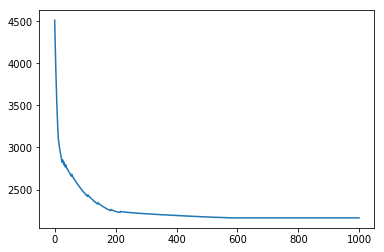

[[ 0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.     0.     0.     0.005  0.     0.     0.     0.   ]]
[[ 0.    0.    0.    0.01  0.    0.    0.    0.  ]]
[[ 0.     0.     0.     0.015  0.     0.     0.     0.   ]]
[[ 0.    0.    0.    0.02  0.    0.    0.    0.  ]]
[[ 0.     0.     0.     0.025  0.     0.     0.     0.   ]]
[[ 0.    0.    0.    0.03  0.    0.    0.    0.  ]]
[[ 0.     0.     0.     0.035  0.     0.     0.     0.   ]]
[[ 0.    0.    0.    0.04  0.    0.    0.    0.  ]]
[[ 0.     0.     0.     0.045  0.     0.     0.     0.   ]]
[[ 0.    0.    0.    0.05  0.    0.    0.    0.  ]]
[[ 0.     0.     0.     0.055  0.     0.     0.     0.   ]]
[[ 0.    0.    0.    0.06  0.    0.    0.    0.  ]]
[[ 0.     0.     0.     0.065  0.     0.     0.     0.   ]]
[[ 0.     0.     0.005  0.065  0.     0.     0.     0.   ]]
[[ 0.     0.     0.005  0.065  0.     0.     0.     0.005]]
[[ 0.     0.     0.005  0.065  0.     0.     0.     0.01 ]]
[[ 0.     0.     0.005  0.065  0.     0.     0.     

[[ 0.     0.     0.035  0.04   0.    -0.295  0.     0.28 ]]
[[ 0.     0.     0.035  0.04   0.    -0.3    0.     0.28 ]]
[[ 0.    0.    0.04  0.04  0.   -0.3   0.    0.28]]
[[ 0.     0.     0.04   0.035  0.    -0.3    0.     0.28 ]]
[[ 0.     0.     0.045  0.035  0.    -0.3    0.     0.28 ]]
[[ 0.     0.     0.045  0.035  0.    -0.3    0.     0.285]]
[[ 0.     0.     0.045  0.035  0.    -0.305  0.     0.285]]
[[ 0.     0.     0.045  0.035  0.    -0.305  0.     0.29 ]]
[[ 0.     0.     0.045  0.035  0.    -0.31   0.     0.29 ]]
[[ 0.     0.     0.045  0.035  0.    -0.315  0.     0.29 ]]
[[ 0.     0.     0.05   0.035  0.    -0.315  0.     0.29 ]]
[[ 0.     0.     0.05   0.035  0.    -0.32   0.     0.29 ]]
[[ 0.     0.     0.05   0.035  0.    -0.325  0.     0.29 ]]
[[ 0.     0.     0.05   0.035  0.    -0.325  0.     0.295]]
[[ 0.     0.     0.05   0.035  0.    -0.33   0.     0.295]]
[[ 0.     0.     0.05   0.035  0.    -0.335  0.     0.295]]
[[ 0.     0.     0.05   0.035  0.    -0.335  0. 

[[ 0.02   0.     0.1    0.025  0.205 -0.61   0.     0.37 ]]
[[ 0.02   0.     0.1    0.025  0.21  -0.61   0.     0.37 ]]
[[ 0.02   0.     0.1    0.025  0.21  -0.615  0.     0.37 ]]
[[ 0.02   0.     0.1    0.025  0.215 -0.615  0.     0.37 ]]
[[ 0.02   0.     0.1    0.025  0.22  -0.615  0.     0.37 ]]
[[ 0.025  0.     0.1    0.025  0.22  -0.615  0.     0.37 ]]
[[ 0.025  0.     0.1    0.025  0.225 -0.615  0.     0.37 ]]
[[ 0.025  0.     0.1    0.025  0.225 -0.615 -0.005  0.37 ]]
[[ 0.025  0.     0.1    0.025  0.23  -0.615 -0.005  0.37 ]]
[[ 0.025  0.     0.1    0.025  0.235 -0.615 -0.005  0.37 ]]
[[ 0.025  0.     0.1    0.025  0.24  -0.615 -0.005  0.37 ]]
[[ 0.025  0.     0.1    0.025  0.245 -0.615 -0.005  0.37 ]]
[[ 0.025  0.     0.1    0.025  0.245 -0.62  -0.005  0.37 ]]
[[ 0.025  0.     0.1    0.025  0.25  -0.62  -0.005  0.37 ]]
[[ 0.025  0.     0.1    0.025  0.255 -0.62  -0.005  0.37 ]]
[[ 0.025  0.     0.1    0.025  0.255 -0.62  -0.005  0.365]]
[[ 0.025  0.     0.1    0.025  0.26  -0.

[[ 0.035  0.     0.105  0.025  0.69  -0.71  -0.03   0.32 ]]
[[ 0.035  0.     0.105  0.025  0.695 -0.71  -0.03   0.32 ]]
[[ 0.035  0.     0.105  0.025  0.7   -0.71  -0.03   0.32 ]]
[[ 0.035  0.     0.105  0.025  0.705 -0.71  -0.03   0.32 ]]
[[ 0.035  0.     0.105  0.025  0.705 -0.715 -0.03   0.32 ]]
[[ 0.035  0.     0.105  0.025  0.71  -0.715 -0.03   0.32 ]]
[[ 0.035  0.     0.105  0.025  0.715 -0.715 -0.03   0.32 ]]
[[ 0.035  0.     0.105  0.025  0.715 -0.715 -0.03   0.315]]
[[ 0.035  0.     0.105  0.025  0.72  -0.715 -0.03   0.315]]
[[ 0.035  0.     0.105  0.025  0.725 -0.715 -0.03   0.315]]
[[ 0.035  0.     0.105  0.025  0.73  -0.715 -0.03   0.315]]
[[ 0.035  0.     0.105  0.025  0.73  -0.72  -0.03   0.315]]
[[ 0.035  0.     0.105  0.025  0.735 -0.72  -0.03   0.315]]
[[ 0.035  0.     0.105  0.025  0.74  -0.72  -0.03   0.315]]
[[ 0.035  0.     0.105  0.025  0.745 -0.72  -0.03   0.315]]
[[ 0.035  0.     0.105  0.025  0.745 -0.72  -0.035  0.315]]
[[ 0.035  0.     0.105  0.025  0.75  -0.

[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.

[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.

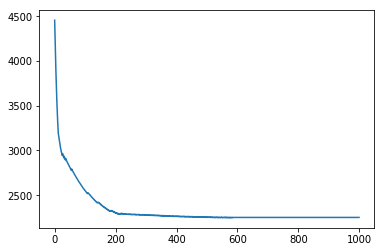

[[ 0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.     0.     0.     0.005  0.     0.     0.     0.   ]]
[[ 0.    0.    0.    0.01  0.    0.    0.    0.  ]]
[[ 0.     0.     0.     0.015  0.     0.     0.     0.   ]]
[[ 0.    0.    0.    0.02  0.    0.    0.    0.  ]]
[[ 0.     0.     0.     0.025  0.     0.     0.     0.   ]]
[[ 0.    0.    0.    0.03  0.    0.    0.    0.  ]]
[[ 0.     0.     0.     0.035  0.     0.     0.     0.   ]]
[[ 0.    0.    0.    0.04  0.    0.    0.    0.  ]]
[[ 0.     0.     0.     0.045  0.     0.     0.     0.   ]]
[[ 0.    0.    0.    0.05  0.    0.    0.    0.  ]]
[[ 0.     0.     0.     0.055  0.     0.     0.     0.   ]]
[[ 0.    0.    0.    0.06  0.    0.    0.    0.  ]]
[[ 0.     0.     0.     0.065  0.     0.     0.     0.   ]]
[[ 0.     0.     0.005  0.065  0.     0.     0.     0.   ]]
[[ 0.     0.     0.005  0.065  0.     0.     0.     0.005]]
[[ 0.     0.     0.005  0.065  0.     0.     0.     0.01 ]]
[[ 0.     0.     0.005  0.065  0.     0.     0.     

[[ 0.005  0.     0.1    0.025  0.09  -0.565  0.     0.375]]
[[ 0.005  0.     0.1    0.025  0.095 -0.565  0.     0.375]]
[[ 0.005  0.     0.1    0.025  0.095 -0.57   0.     0.375]]
[[ 0.005  0.     0.1    0.025  0.1   -0.57   0.     0.375]]
[[ 0.005  0.     0.1    0.025  0.105 -0.57   0.     0.375]]
[[ 0.005  0.     0.1    0.025  0.105 -0.575  0.     0.375]]
[[ 0.005  0.     0.1    0.025  0.11  -0.575  0.     0.375]]
[[ 0.005  0.     0.1    0.025  0.115 -0.575  0.     0.375]]
[[ 0.01   0.     0.1    0.025  0.115 -0.575  0.     0.375]]
[[ 0.01   0.     0.1    0.025  0.115 -0.58   0.     0.375]]
[[ 0.01   0.     0.1    0.025  0.12  -0.58   0.     0.375]]
[[ 0.01   0.     0.1    0.025  0.125 -0.58   0.     0.375]]
[[ 0.015  0.     0.1    0.025  0.125 -0.58   0.     0.375]]
[[ 0.015  0.     0.1    0.025  0.13  -0.58   0.     0.375]]
[[ 0.015  0.     0.1    0.025  0.13  -0.585  0.     0.375]]
[[ 0.015  0.     0.1    0.025  0.135 -0.585  0.     0.375]]
[[ 0.015  0.     0.1    0.025  0.14  -0.

[[ 0.04   0.     0.105  0.025  1.165 -0.805 -0.055  0.275]]
[[ 0.04   0.     0.105  0.025  1.17  -0.805 -0.055  0.275]]
[[ 0.04   0.     0.105  0.025  1.17  -0.805 -0.055  0.27 ]]
[[ 0.04   0.     0.105  0.025  1.175 -0.805 -0.055  0.27 ]]
[[ 0.04   0.     0.105  0.025  1.18  -0.805 -0.055  0.27 ]]
[[ 0.04   0.     0.105  0.025  1.185 -0.805 -0.055  0.27 ]]
[[ 0.045  0.     0.105  0.025  1.185 -0.805 -0.055  0.27 ]]
[[ 0.045  0.     0.105  0.025  1.185 -0.81  -0.055  0.27 ]]
[[ 0.045  0.     0.105  0.025  1.19  -0.81  -0.055  0.27 ]]
[[ 0.045  0.     0.105  0.025  1.195 -0.81  -0.055  0.27 ]]
[[ 0.045  0.     0.105  0.025  1.2   -0.81  -0.055  0.27 ]]
[[ 0.045  0.     0.105  0.025  1.2   -0.81  -0.055  0.265]]
[[ 0.045  0.     0.105  0.025  1.205 -0.81  -0.055  0.265]]
[[ 0.045  0.     0.105  0.025  1.21  -0.81  -0.055  0.265]]
[[ 0.045  0.     0.105  0.025  1.215 -0.81  -0.055  0.265]]
[[ 0.045  0.     0.105  0.025  1.215 -0.815 -0.055  0.265]]
[[ 0.045  0.     0.105  0.025  1.22  -0.

[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.

[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]


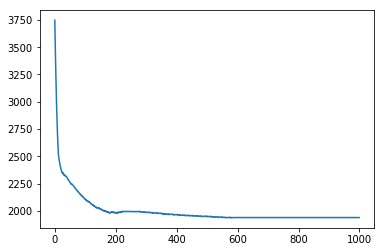

[[ 0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.     0.     0.     0.005  0.     0.     0.     0.   ]]
[[ 0.    0.    0.    0.01  0.    0.    0.    0.  ]]
[[ 0.     0.     0.     0.015  0.     0.     0.     0.   ]]
[[ 0.    0.    0.    0.02  0.    0.    0.    0.  ]]
[[ 0.     0.     0.     0.025  0.     0.     0.     0.   ]]
[[ 0.    0.    0.    0.03  0.    0.    0.    0.  ]]
[[ 0.     0.     0.     0.035  0.     0.     0.     0.   ]]
[[ 0.    0.    0.    0.04  0.    0.    0.    0.  ]]
[[ 0.     0.     0.     0.045  0.     0.     0.     0.   ]]
[[ 0.    0.    0.    0.05  0.    0.    0.    0.  ]]
[[ 0.     0.     0.     0.055  0.     0.     0.     0.   ]]
[[ 0.    0.    0.    0.06  0.    0.    0.    0.  ]]
[[ 0.     0.     0.     0.065  0.     0.     0.     0.   ]]
[[ 0.     0.     0.005  0.065  0.     0.     0.     0.   ]]
[[ 0.     0.     0.005  0.065  0.     0.     0.     0.005]]
[[ 0.     0.     0.005  0.065  0.     0.     0.     0.01 ]]
[[ 0.     0.     0.005  0.065  0.     0.     0.     

[[ 0.     0.     0.1    0.025  0.035 -0.54   0.     0.375]]
[[ 0.     0.     0.1    0.025  0.04  -0.54   0.     0.375]]
[[ 0.     0.     0.1    0.025  0.04  -0.545  0.     0.375]]
[[ 0.     0.     0.1    0.025  0.045 -0.545  0.     0.375]]
[[ 0.     0.     0.1    0.025  0.05  -0.545  0.     0.375]]
[[ 0.     0.     0.1    0.025  0.05  -0.55   0.     0.375]]
[[ 0.     0.     0.1    0.025  0.055 -0.55   0.     0.375]]
[[ 0.     0.     0.1    0.025  0.06  -0.55   0.     0.375]]
[[ 0.     0.     0.1    0.025  0.06  -0.555  0.     0.375]]
[[ 0.     0.     0.1    0.025  0.065 -0.555  0.     0.375]]
[[ 0.     0.     0.1    0.025  0.07  -0.555  0.     0.375]]
[[ 0.005  0.     0.1    0.025  0.07  -0.555  0.     0.375]]
[[ 0.005  0.     0.1    0.025  0.07  -0.56   0.     0.375]]
[[ 0.005  0.     0.1    0.025  0.075 -0.56   0.     0.375]]
[[ 0.005  0.     0.1    0.025  0.08  -0.56   0.     0.375]]
[[ 0.005  0.     0.1    0.025  0.085 -0.56   0.     0.375]]
[[ 0.005  0.     0.1    0.025  0.085 -0.

[[ 0.035  0.     0.105  0.025  0.645 -0.7   -0.025  0.325]]
[[ 0.035  0.     0.105  0.025  0.645 -0.705 -0.025  0.325]]
[[ 0.035  0.     0.105  0.025  0.65  -0.705 -0.025  0.325]]
[[ 0.035  0.     0.105  0.025  0.655 -0.705 -0.025  0.325]]
[[ 0.035  0.     0.105  0.025  0.655 -0.705 -0.025  0.32 ]]
[[ 0.035  0.     0.105  0.025  0.66  -0.705 -0.025  0.32 ]]
[[ 0.035  0.     0.105  0.025  0.665 -0.705 -0.025  0.32 ]]
[[ 0.035  0.     0.105  0.025  0.67  -0.705 -0.025  0.32 ]]
[[ 0.035  0.     0.105  0.025  0.67  -0.71  -0.025  0.32 ]]
[[ 0.035  0.     0.105  0.025  0.675 -0.71  -0.025  0.32 ]]
[[ 0.035  0.     0.105  0.025  0.68  -0.71  -0.025  0.32 ]]
[[ 0.035  0.     0.105  0.025  0.685 -0.71  -0.025  0.32 ]]
[[ 0.035  0.     0.105  0.025  0.685 -0.71  -0.03   0.32 ]]
[[ 0.035  0.     0.105  0.025  0.69  -0.71  -0.03   0.32 ]]
[[ 0.035  0.     0.105  0.025  0.695 -0.71  -0.03   0.32 ]]
[[ 0.035  0.     0.105  0.025  0.7   -0.71  -0.03   0.32 ]]
[[ 0.035  0.     0.105  0.025  0.705 -0.

[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.

[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.

[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]


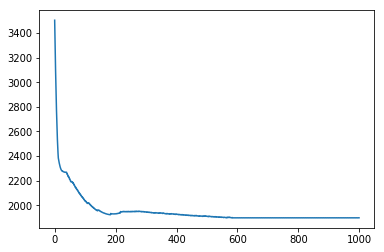

[[ 0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.     0.     0.     0.005  0.     0.     0.     0.   ]]
[[ 0.    0.    0.    0.01  0.    0.    0.    0.  ]]
[[ 0.     0.     0.     0.015  0.     0.     0.     0.   ]]
[[ 0.    0.    0.    0.02  0.    0.    0.    0.  ]]
[[ 0.     0.     0.     0.025  0.     0.     0.     0.   ]]
[[ 0.    0.    0.    0.03  0.    0.    0.    0.  ]]
[[ 0.     0.     0.     0.035  0.     0.     0.     0.   ]]
[[ 0.    0.    0.    0.04  0.    0.    0.    0.  ]]
[[ 0.     0.     0.     0.045  0.     0.     0.     0.   ]]
[[ 0.    0.    0.    0.05  0.    0.    0.    0.  ]]
[[ 0.     0.     0.     0.055  0.     0.     0.     0.   ]]
[[ 0.    0.    0.    0.06  0.    0.    0.    0.  ]]
[[ 0.     0.     0.     0.065  0.     0.     0.     0.   ]]
[[ 0.     0.     0.005  0.065  0.     0.     0.     0.   ]]
[[ 0.     0.     0.005  0.065  0.     0.     0.     0.005]]
[[ 0.     0.     0.005  0.065  0.     0.     0.     0.01 ]]
[[ 0.     0.     0.005  0.065  0.     0.     0.     

[[ 0.     0.     0.05   0.035  0.    -0.33   0.     0.295]]
[[ 0.     0.     0.05   0.035  0.    -0.335  0.     0.295]]
[[ 0.     0.     0.05   0.035  0.    -0.335  0.     0.3  ]]
[[ 0.     0.     0.05   0.035  0.    -0.34   0.     0.3  ]]
[[ 0.     0.     0.05   0.035  0.    -0.345  0.     0.3  ]]
[[ 0.     0.     0.055  0.035  0.    -0.345  0.     0.3  ]]
[[ 0.     0.     0.055  0.035  0.    -0.35   0.     0.3  ]]
[[ 0.     0.     0.055  0.035  0.    -0.355  0.     0.3  ]]
[[ 0.     0.     0.055  0.035  0.    -0.355  0.     0.305]]
[[ 0.     0.     0.055  0.035  0.    -0.36   0.     0.305]]
[[ 0.     0.     0.055  0.035  0.    -0.36   0.     0.31 ]]
[[ 0.     0.     0.055  0.035  0.    -0.365  0.     0.31 ]]
[[ 0.     0.     0.055  0.035  0.    -0.37   0.     0.31 ]]
[[ 0.     0.     0.06   0.035  0.    -0.37   0.     0.31 ]]
[[ 0.     0.     0.06   0.035  0.    -0.375  0.     0.31 ]]
[[ 0.     0.     0.06   0.035  0.    -0.38   0.     0.31 ]]
[[ 0.     0.     0.06   0.035  0.    -0.

[[ 0.035  0.     0.105  0.025  0.635 -0.7   -0.025  0.325]]
[[ 0.035  0.     0.105  0.025  0.64  -0.7   -0.025  0.325]]
[[ 0.035  0.     0.105  0.025  0.645 -0.7   -0.025  0.325]]
[[ 0.035  0.     0.105  0.025  0.645 -0.705 -0.025  0.325]]
[[ 0.035  0.     0.105  0.025  0.65  -0.705 -0.025  0.325]]
[[ 0.035  0.     0.105  0.025  0.655 -0.705 -0.025  0.325]]
[[ 0.035  0.     0.105  0.025  0.655 -0.705 -0.025  0.32 ]]
[[ 0.035  0.     0.105  0.025  0.66  -0.705 -0.025  0.32 ]]
[[ 0.035  0.     0.105  0.025  0.665 -0.705 -0.025  0.32 ]]
[[ 0.035  0.     0.105  0.025  0.67  -0.705 -0.025  0.32 ]]
[[ 0.035  0.     0.105  0.025  0.67  -0.71  -0.025  0.32 ]]
[[ 0.035  0.     0.105  0.025  0.675 -0.71  -0.025  0.32 ]]
[[ 0.035  0.     0.105  0.025  0.68  -0.71  -0.025  0.32 ]]
[[ 0.035  0.     0.105  0.025  0.685 -0.71  -0.025  0.32 ]]
[[ 0.035  0.     0.105  0.025  0.685 -0.71  -0.03   0.32 ]]
[[ 0.035  0.     0.105  0.025  0.69  -0.71  -0.03   0.32 ]]
[[ 0.035  0.     0.105  0.025  0.695 -0.

[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.

[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.

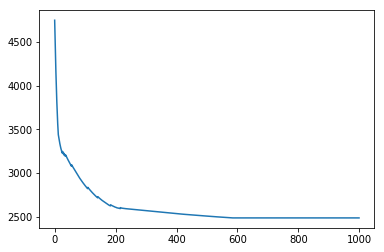

[[ 0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.     0.     0.     0.005  0.     0.     0.     0.   ]]
[[ 0.    0.    0.    0.01  0.    0.    0.    0.  ]]
[[ 0.     0.     0.     0.015  0.     0.     0.     0.   ]]
[[ 0.    0.    0.    0.02  0.    0.    0.    0.  ]]
[[ 0.     0.     0.     0.025  0.     0.     0.     0.   ]]
[[ 0.    0.    0.    0.03  0.    0.    0.    0.  ]]
[[ 0.     0.     0.     0.035  0.     0.     0.     0.   ]]
[[ 0.    0.    0.    0.04  0.    0.    0.    0.  ]]
[[ 0.     0.     0.     0.045  0.     0.     0.     0.   ]]
[[ 0.    0.    0.    0.05  0.    0.    0.    0.  ]]
[[ 0.     0.     0.     0.055  0.     0.     0.     0.   ]]
[[ 0.    0.    0.    0.06  0.    0.    0.    0.  ]]
[[ 0.     0.     0.     0.065  0.     0.     0.     0.   ]]
[[ 0.     0.     0.005  0.065  0.     0.     0.     0.   ]]
[[ 0.     0.     0.005  0.065  0.     0.     0.     0.005]]
[[ 0.     0.     0.005  0.065  0.     0.     0.     0.01 ]]
[[ 0.     0.     0.005  0.065  0.     0.     0.     

[[ 0.     0.     0.07   0.035  0.    -0.425  0.     0.33 ]]
[[ 0.     0.     0.07   0.03   0.    -0.425  0.     0.33 ]]
[[ 0.     0.     0.075  0.03   0.    -0.425  0.     0.33 ]]
[[ 0.     0.     0.075  0.03   0.    -0.425  0.     0.335]]
[[ 0.     0.     0.075  0.03   0.    -0.43   0.     0.335]]
[[ 0.     0.     0.075  0.03   0.    -0.43   0.     0.34 ]]
[[ 0.     0.     0.075  0.03   0.    -0.435  0.     0.34 ]]
[[ 0.     0.     0.075  0.03   0.    -0.44   0.     0.34 ]]
[[ 0.    0.    0.08  0.03  0.   -0.44  0.    0.34]]
[[ 0.     0.     0.08   0.03   0.    -0.445  0.     0.34 ]]
[[ 0.    0.    0.08  0.03  0.   -0.45  0.    0.34]]
[[ 0.     0.     0.08   0.03   0.    -0.45   0.     0.345]]
[[ 0.     0.     0.08   0.03   0.    -0.455  0.     0.345]]
[[ 0.     0.     0.08   0.03   0.    -0.46   0.     0.345]]
[[ 0.     0.     0.085  0.03   0.    -0.46   0.     0.345]]
[[ 0.     0.     0.085  0.03   0.    -0.465  0.     0.345]]
[[ 0.     0.     0.085  0.03   0.    -0.47   0.     0.34

[[ 0.03   0.     0.105  0.025  0.485 -0.665 -0.02   0.34 ]]
[[ 0.03   0.     0.105  0.025  0.49  -0.665 -0.02   0.34 ]]
[[ 0.03   0.     0.105  0.025  0.495 -0.665 -0.02   0.34 ]]
[[ 0.03   0.     0.105  0.025  0.495 -0.67  -0.02   0.34 ]]
[[ 0.03   0.     0.105  0.025  0.5   -0.67  -0.02   0.34 ]]
[[ 0.03   0.     0.105  0.025  0.505 -0.67  -0.02   0.34 ]]
[[ 0.03   0.     0.105  0.025  0.505 -0.675 -0.02   0.34 ]]
[[ 0.03   0.     0.105  0.025  0.51  -0.675 -0.02   0.34 ]]
[[ 0.03   0.     0.105  0.025  0.515 -0.675 -0.02   0.34 ]]
[[ 0.03   0.     0.105  0.025  0.52  -0.675 -0.02   0.34 ]]
[[ 0.03   0.     0.105  0.025  0.52  -0.675 -0.02   0.335]]
[[ 0.03   0.     0.105  0.025  0.525 -0.675 -0.02   0.335]]
[[ 0.03   0.     0.105  0.025  0.53  -0.675 -0.02   0.335]]
[[ 0.03   0.     0.105  0.025  0.535 -0.675 -0.02   0.335]]
[[ 0.03   0.     0.105  0.025  0.535 -0.68  -0.02   0.335]]
[[ 0.03   0.     0.105  0.025  0.54  -0.68  -0.02   0.335]]
[[ 0.03   0.     0.105  0.025  0.545 -0.

[[ 0.045  0.     0.105  0.025  1.245 -0.825 -0.055  0.265]]
[[ 0.045  0.     0.105  0.025  1.25  -0.825 -0.055  0.265]]
[[ 0.045  0.     0.105  0.025  1.25  -0.825 -0.06   0.265]]
[[ 0.045  0.     0.105  0.025  1.255 -0.825 -0.06   0.265]]
[[ 0.045  0.     0.105  0.025  1.26  -0.825 -0.06   0.265]]
[[ 0.045  0.     0.105  0.025  1.265 -0.825 -0.06   0.265]]
[[ 0.045  0.     0.105  0.025  1.27  -0.825 -0.06   0.265]]
[[ 0.045  0.     0.105  0.025  1.27  -0.825 -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.275 -0.825 -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.28  -0.825 -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.285 -0.825 -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.285 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.29  -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.

[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.

[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]


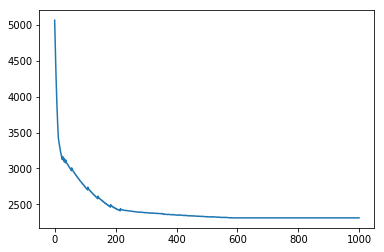

best model:[[  0.06657618   0.          10.66401985  14.2931972    5.3447284
  -16.85082254  -4.99483562  13.42091746]]
with constant term:
2.90931495118


In [53]:
crossValidation2(xArr,yArr,numVal = 10)